# Project Part 3 - RateMyProfessor Deep Learning Model

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/eboyer221/CS39AA-project/blob/main/project_part3.ipynb)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eboyer221/CS39AA-project/blob/main/project_part3.ipynb)

For Part 3 of this Project I will be using the 'BertForSequenceClassification' model for binary classification. This code will attempt to fine-tune BERT using the 'transformers' library by HuggingFace.

In [5]:
#!pip install transformers[torch]
#!pip install tqdm[concurrent]
#!pip install --upgrade tqdm

In [6]:
#install packages
import pandas as pd
import numpy as np
import nltk
import torch
import torch.nn.functional as F
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import torch.cuda
import datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification,  TrainingArguments, Trainer
from datasets import Dataset, load_metric

In [51]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
       # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [52]:
# Load the ratemyprofessor ratings dataset
data_path = 'https://raw.githubusercontent.com/eboyer221/CS39AA-Project/main/merged_data.csv'
df_1 = pd.read_csv(data_path)

In [32]:
#Apply cleaning steps to the dataset
#remove rows that have null values in either of these columns
columns_to_check = ['student_star', 'comments']

# Remove rows with null values in either of the specified columns
df_1 = df_1.dropna(subset=columns_to_check)

# Reset the index after removing rows
df_1.reset_index(drop=True, inplace=True)
# Columns to remove 
columns_to_remove = ['school_name', 'local_name', 'state_name',
                    'year_since_first_review', 'take_again', 'diff_index',
                    'tag_professor', 'post_date', 'name_onlines', 'attence',
                    'for_credits', 'would_take_agains', 'grades', 'stu_tags',
                    'help_useful', 'help_not_useful', 'professor_name', 'department_name',
                    'num_student', 'star_rating', 'student_difficult']

# Drop the specified columns
df = df_1.drop(columns=columns_to_remove)

#Change the pandas default column width to view more of the comments field
pd.set_option("display.max_colwidth", 370)

df.head()

,student_star,comments
0,3.5,"Good guy, laid back and interested in his field. Class can get... a little..... slllllllloooooowwwwwwww during his junior workshop."
1,5.0,such a fun professor. really helpful and knows his stuff
2,5.0,Such a easy class. It\'s simple. Do your homework and pay attention and you will fly right by or be the person that blames him for not leaarning. He wont let you fail. just ask for help....
3,5.0,"A very hard class, and a massive amount of work. But, Soazig is also very good about explaining difficult concepts, gives excellent feedback, and is very accessible for extra assistance."
4,1.0,"Took 100 level class for Ethics offered online as an option to fill a core requirement She was terrible! Did not seem to have a grasp of the English language nor does she seem to have a grasp on reality as she insisted many times that failure in an ENTRY LEVEL, OPTIONAL class is very common due to the ""difficulty"" of material, very full of herself"


The variable that I am primarily focused on predicting using comments is the star rating of the professor's overall quality. This is a continuous numerical variable, however it can be conceptually broken up into quality categories. According to RMP’s official standard, a rating of 3.5-5.0 is good, 2.5-3.4 is average and 1.0-2.4 is poor.

In [33]:
#Create a new rating column that reflects the sentiment where:
#ratings that are greater than or equal to 3.5 are considered positive
# ratings of 2.5-3.4 are considered neutral
#ratings that are less than 3.5 are considered negative

# Function to categorize ratings
def categorize_sentiment(rating):
    if rating >= 3.5:
        return 'positive'
    elif 2.5 <= rating < 3.5:
        return 'neutral'
    else:
        return 'negative'

# Create a new column 'rating_sentiment' based on the 'student_star' column
df['rating_sentiment'] = df['student_star'].apply(categorize_sentiment)

rating_result_counts = df['rating_sentiment'].value_counts()

# Display the counts
print(rating_result_counts)

df.head(10)

rating_sentiment
positive    13549
negative     4095
neutral      1940
Name: count, dtype: int64


,student_star,comments,rating_sentiment
0,3.5,"Good guy, laid back and interested in his field. Class can get... a little..... slllllllloooooowwwwwwww during his junior workshop.",positive
1,5.0,such a fun professor. really helpful and knows his stuff,positive
2,5.0,Such a easy class. It\'s simple. Do your homework and pay attention and you will fly right by or be the person that blames him for not leaarning. He wont let you fail. just ask for help....,positive
3,5.0,"A very hard class, and a massive amount of work. But, Soazig is also very good about explaining difficult concepts, gives excellent feedback, and is very accessible for extra assistance.",positive
4,1.0,"Took 100 level class for Ethics offered online as an option to fill a core requirement She was terrible! Did not seem to have a grasp of the English language nor does she seem to have a grasp on reality as she insisted many times that failure in an ENTRY LEVEL, OPTIONAL class is very common due to the ""difficulty"" of material, very full of herself",negative
5,3.5,No Comments,positive
6,5.0,"She is an extremely demanding professor. The work load is a big one. But she is also extremely helpful and explains things very clearly. She\'s not a professor for slackers... not and easy A, but definitely not impossible. Show up. Pay attention. Ask for help.",positive
7,3.0,"Boo. When I took multicultural psych from Dr. Swaney it was more like Salish Psych. The first day (of a 300 level class!) we went over APA style guidelines and how to use blackboard. She\'s a nice person, but should not be teaching at a college level.",neutral
8,5.0,Steph was very helpful and cared about our experience. She wanted to be sure we learned and were comfortable with everything before our testing. Go to her office hours if you need help. I learned a lot.,positive
9,5.0,One of the best classes I took at UM.,positive


In [34]:
MODEL_NAME = "bert-base-cased"
MAX_LENGTH=50

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3, max_length=MAX_LENGTH, output_attentions=False, output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Create three categories for ratings: positive, neutral, and negative to investigate the BERT model performance on a multinomial classification problem with three possible segments for ratings.

In [35]:
classes = df.rating_sentiment.unique().tolist()
class_tok2idx = dict((v, k) for k, v in enumerate(classes))
class_idx2tok = dict((k, v) for k, v in enumerate(classes))
print(class_tok2idx)
print(class_idx2tok)

{'positive': 0, 'negative': 1, 'neutral': 2}
{0: 'positive', 1: 'negative', 2: 'neutral'}


Create a new column with these new labels. This will be the y that is used.

In [36]:
df['label'] = df['rating_sentiment'].apply(lambda x: class_tok2idx[x])
df.head()

,student_star,comments,rating_sentiment,label
0,3.5,"Good guy, laid back and interested in his field. Class can get... a little..... slllllllloooooowwwwwwww during his junior workshop.",positive,0
1,5.0,such a fun professor. really helpful and knows his stuff,positive,0
2,5.0,Such a easy class. It\'s simple. Do your homework and pay attention and you will fly right by or be the person that blames him for not leaarning. He wont let you fail. just ask for help....,positive,0
3,5.0,"A very hard class, and a massive amount of work. But, Soazig is also very good about explaining difficult concepts, gives excellent feedback, and is very accessible for extra assistance.",positive,0
4,1.0,"Took 100 level class for Ethics offered online as an option to fill a core requirement She was terrible! Did not seem to have a grasp of the English language nor does she seem to have a grasp on reality as she insisted many times that failure in an ENTRY LEVEL, OPTIONAL class is very common due to the ""difficulty"" of material, very full of herself",negative,1


In [37]:
sequence_0 = "A very hard class, and a massive amount of work. But, Soazig is also very good about explaining difficult concepts, gives excellent feedback, and is very accessible for extra assistance."
seq0_tokens = tokenizer(sequence_0, return_tensors="pt")
print(f"number of tokens in seq0 is {len(seq0_tokens['input_ids'].flatten())}")
print(seq0_tokens)
F.softmax(model(**seq0_tokens).logits, dim=1)

number of tokens in seq0 is 40
{'input_ids': tensor([[  101,   138,  1304,  1662,  1705,   117,  1105,   170,  4672,  2971,
          1104,  1250,   119,  1252,   117,  1573, 19888,  1403,  1110,  1145,
          1304,  1363,  1164, 10100,  2846,  8550,   117,  3114,  6548, 13032,
           117,  1105,  1110,  1304,  7385,  1111,  3908,  5052,   119,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


tensor([[0.3282, 0.3457, 0.3261]], grad_fn=<SoftmaxBackward0>)

In [38]:
ds_raw = Dataset.from_pandas(df[['label','comments']])
ds_raw[0]

{'label': 0,
 'comments': 'Good guy, laid back and interested in his field. Class can get... a little..... slllllllloooooowwwwwwww during his junior workshop.'}

In [39]:
def tokenize_function(examples):
    return tokenizer(examples["comments"], padding="max_length", truncation=True, max_length=MAX_LENGTH)

ds = ds_raw.map(tokenize_function, batched=True)

In [40]:
ds[0]

{'label': 0,
 'comments': 'Good guy, laid back and interested in his field. Class can get... a little..... slllllllloooooowwwwwwww during his junior workshop.',
 'input_ids': [101,
  2750,
  2564,
  117,
  3390,
  1171,
  1105,
  3888,
  1107,
  1117,
  1768,
  119,
  3699,
  1169,
  1243,
  119,
  119,
  119,
  170,
  1376,
  119,
  119,
  119,
  119,
  119,
  188,
  2339,
  2339,
  2339,
  6643,
  5658,
  5658,
  4064,
  2246,
  2246,
  2246,
  2246,
  2246,
  2246,
  2246,
  1219,
  1117,
  4635,
  10819,
  119,
  102,
  0,
  0,
  0,
  0],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,

In [41]:
ds = ds.shuffle(seed=42)
ds[0]

{'label': 2,
 'comments': 'Does not follow her own syllabus. Seems to forget what she has requested of her classes, or confuses assignments. "Does not believe there is a perfect paper," her own quote. Slow to respond via e-mail. Tries to be helpful. Read the book yourself, just don\\\'t go too far ahead because she may not get that far with the class.',
 'input_ids': [101,
  7187,
  1136,
  2812,
  1123,
  1319,
  188,
  7777,
  1742,
  7441,
  119,
  25686,
  1106,
  5042,
  1184,
  1131,
  1144,
  6792,
  1104,
  1123,
  3553,
  117,
  1137,
  14255,
  23718,
  1116,
  15799,
  119,
  107,
  7187,
  1136,
  2059,
  1175,
  1110,
  170,
  3264,
  2526,
  117,
  107,
  1123,
  1319,
  15882,
  119,
  19826,
  1106,
  6297,
  2258,
  174,
  118,
  102],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [42]:
train_prop = 0.85
ds_train = ds.select(range(int(len(ds)*train_prop)))
ds_eval = ds.select(range(int(len(ds)*train_prop), len(ds)))

In [43]:
print(f"len(ds_train) = {len(ds_train)}")
print(f"len(ds_eval) = {len(ds_eval)}")

len(ds_train) = 16646
len(ds_eval) = 2938


In [44]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [1]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(num_train_epochs=5,
                                  do_train=True,
                                  report_to=None,
                                  output_dir="/kaggle/working/output_dir",
                                  evaluation_strategy="steps",
                                  eval_steps=200,
                                  learning_rate=1e-5,
                                  per_device_train_batch_size=32,
                                  per_device_eval_batch_size=32)

trainer = Trainer(model = model, 
                  args = training_args,
                  train_dataset = ds_train, 
                  eval_dataset = ds_eval,
                  compute_metrics = compute_metrics,
)

'metric = load_metric("accuracy")\n\ndef compute_metrics(eval_pred):\n    logits, labels = eval_pred\n    predictions = np.argmax(logits, axis=-1)\n    return metric.compute(predictions=predictions, references=labels)\n\ntraining_args = TrainingArguments(num_train_epochs=5,\n                                  do_train=True,\n                                  report_to=None,\n                                  output_dir="/kaggle/working/output_dir",\n                                  evaluation_strategy="steps",\n                                  eval_steps=200,\n                                  learning_rate=1e-5,\n                                  per_device_train_batch_size=32,\n                                  per_device_eval_batch_size=32)\n\ntrainer = Trainer(model = model, \n                  args = training_args,\n                  train_dataset = ds_train, \n                  eval_dataset = ds_eval,\n                  compute_metrics = compute_metrics,\n)'

In [46]:
if torch.cuda.is_available():
    device = "cuda:0"
    print("Using GPU")
else: 
    device = "cpu"

In [47]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [2]:
torch.set_grad_enabled(True)
trainer.train()
trainer.evaluate()

'torch.set_grad_enabled(True)\ntrainer.train()\ntrainer.evaluate()'

When the BertforSequenceClassification model is used to classify three categories ('positive', 'neutral', and 'negative') the overall accuracy is around 84%. The results below reflect that model.

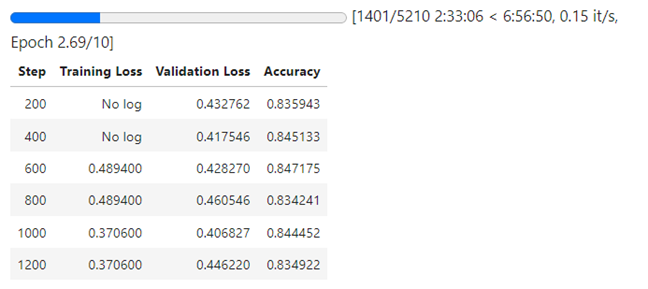

Performance improves when the classification is binary instead. Below is a screenshot of the results of the BertForSequenceClassification after running for 5 epochs with the binary classification of 1 or 0 for ratings >=3.5 ("positive") or <3.5 ("negative").
The overall accuracy is approximatly 89% for this binary classification model which is the best performing model so far. 

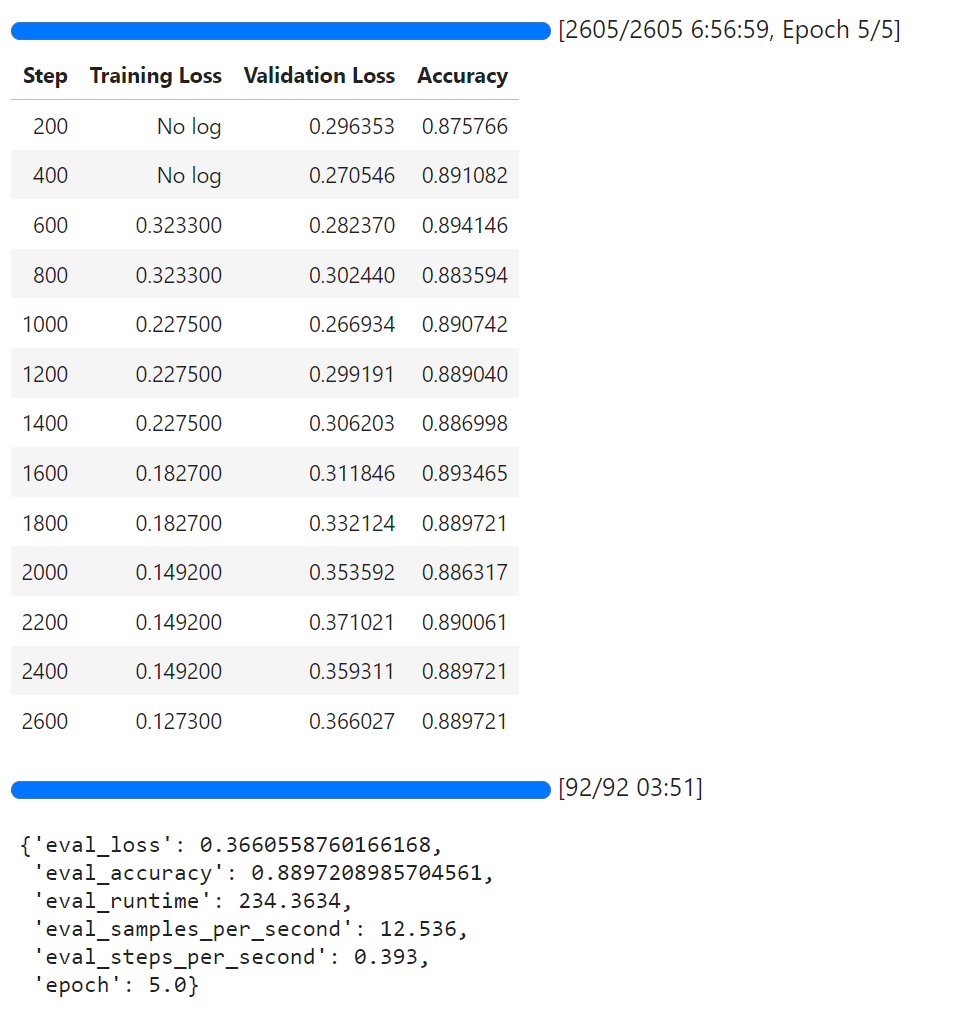

Summary/Conclusion:

The BertforSequenceClassification model performed best with this dataset when performing binary classification of ratings. It was particularly difficult for any model to categorize neutral ratings based on reviews wtih the original dataset. This could be due to the fact that neutral ratings account for only 10% of the data. If this analysis was to be carried out again it would be helpful to have a more balanced dataset with more neutral/average ratings included to determine whether they can be correctly identified.